<a href="https://colab.research.google.com/github/mshakerinava/IFT6269-A20-proj6/blob/main/ift_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np

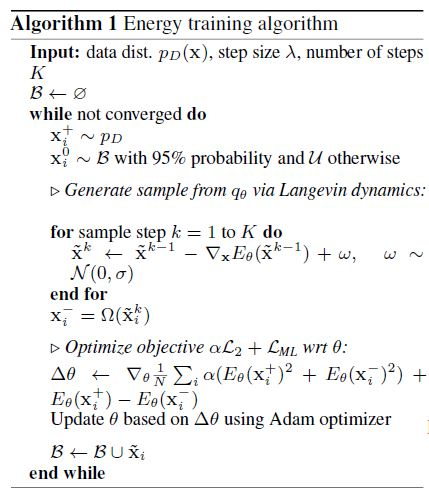

In [ ]:
# Number of steps
K = 10
# Step Size
batch_size_train=64
batch_size_test=64

mnist_transform =torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()
                                     ])
mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test =  MNIST(root='./data', train=False, download=True, transform=mnist_transform)
#rand_loader = torch.utils.data.RandomSampler(mnist_train)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1 )
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1)
#dataset = train_loader

B = []
learning_rate = 0.01
alpha = 1e-3
sigma = 0.3
input_size = 28*28
output_size = 1
n_epochs = 10
net = nn.Linear(input_size, output_size)
optimizer = optim.Adam(net.parameters(), lr=learning_rate) 
# Number of Langevin Dynamics steps
K = 10

class net(nn.Module):
      def __init__(self):
        super(net, self).__init__()
        


def sample(net, B, shape, sigma):
    ''' samples one image with Langevin dynamics '''
    # Get our x0 either from uniform noise, or reply buffer
    if np.random.random_sample() > 0.95 or len(B)==0:
        x0 = torch.FloatTensor(shape).uniform_(0, 1)
    else:
        x0 = np.random.choice(B)

    x = x0.clone().detach()
    x.requires_grad = True
    for k in range(K):
        w = torch.normal(torch.zeros(shape), sigma * torch.ones(shape))
        x  = x - torch.autograd.grad(outputs=net(x), inputs=x)[0] - w
    
    return x



def loss_fcn(net, x_pos, x_neg, alpha):
    return torch.mean(alpha*(net(x_pos)**2 + net(x_neg)**2) + net(x_pos) - net(x_neg))



In [ ]:
class ResBlock(nn.Module):
  #stride?
  def __init__(self, in_size, out_size, stride=1):
        super(ResBlock, self).__init__()

        self.stride = stride
        self.conv_block1 = nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1)
        self.conv_block2 = nn.Conv2d(out_size, out_size, kernel_size=3,  stride=1, padding=1)
        # self.batch_norm = nn.BatchNorm2d(out_size)
        self.avgPool = nn.AvgPool2d(kernel_size=stride, stride=stride)

        self.identity_pad = nn.Sequential()
        if in_size != out_size or stride!=1: #we don't want to change dim for the 1st residual block layers, why?
           self.identity_pad =  nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size=1, stride=1))

  def forward(self, x):
    if self.stride>1:
      x = self.avgPool(x)
    out_block = self.conv_block1(x)
    out_block = F.relu(out_block)
    out_block = self.conv_block2(out_block)
    out_block = F.leaky_relu(out_block)
    return out_block + self.identity_pad(x)

In [ ]:
def res_block_layers(in_size, out_size, num_res_block, stride=1):
    layers = []

    #append the first layer
    layers.append(ResBlock(in_size, out_size, stride))

    #append the remaining layers
    for i in range(1, num_res_block):
        layers.append(ResBlock(out_size, out_size))
        
    return nn.Sequential(*layers)

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.conv = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3)
        self.batch_norm = nn.BatchNorm2d(64) 
        self.maxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #check the numbers? why??

        self.res_block1 = res_block_layers(64, 64, 3, stride=1)
        self.res_block2 = res_block_layers(64, 128, 4, stride=2)
        self.res_block3 = res_block_layers(128, 256, 6, stride=2)
        self.res_block4 = res_block_layers(256, 512, 3, stride=2)

        self.avgPool = nn.AvgPool2d((1,1)) 
        self.linear = nn.Linear(512, 1)

    def forward(self, x):
      x = self.conv(x)
      # x = self.batch_norm(x)
      x = F.leaky_relu(x)
      x = self.maxPool(x)

      #residual blocks
      x = self.res_block1(x) 
      x = self.res_block2(x) 
      x = self.res_block3(x) 
      x = self.res_block4(x)

      #check size?
      x = self.avgPool(x)

      x = torch.flatten(x, 1)
      x = self.linear(x)
      return x

In [ ]:
B = []
n_epochs = 100
for epoch in range(n_epochs):
    running_loss = 0
    x_pos, _ = next(iter(train_loader))
    x_pos = x_pos.flatten()
    x_sample = sample(net, B, input_size, sigma)
    x_neg = x_sample.detach()
    B.append(x_sample)

    y = 1
    optimizer.zero_grad()
    loss = loss_fcn(net, x_pos, x_neg, alpha)
    loss.backward()
    optimizer.step()
    print(loss)


tensor(18.8846, grad_fn=<MeanBackward0>)
tensor(49.4825, grad_fn=<MeanBackward0>)
tensor(81.1945, grad_fn=<MeanBackward0>)
tensor(45.7338, grad_fn=<MeanBackward0>)
tensor(71.0618, grad_fn=<MeanBackward0>)
tensor(94.8279, grad_fn=<MeanBackward0>)
tensor(50.5586, grad_fn=<MeanBackward0>)
tensor(102.1795, grad_fn=<MeanBackward0>)
tensor(20.3329, grad_fn=<MeanBackward0>)
tensor(36.0370, grad_fn=<MeanBackward0>)
tensor(53.9064, grad_fn=<MeanBackward0>)
tensor(26.7150, grad_fn=<MeanBackward0>)
tensor(48.7023, grad_fn=<MeanBackward0>)
tensor(-4.6288, grad_fn=<MeanBackward0>)
tensor(14.0561, grad_fn=<MeanBackward0>)
tensor(-20.2849, grad_fn=<MeanBackward0>)
tensor(-16.2429, grad_fn=<MeanBackward0>)
tensor(-34.6136, grad_fn=<MeanBackward0>)
tensor(-16.4819, grad_fn=<MeanBackward0>)
tensor(-7.2069, grad_fn=<MeanBackward0>)
tensor(-45.9657, grad_fn=<MeanBackward0>)
tensor(-10.7599, grad_fn=<MeanBackward0>)
tensor(-63.8384, grad_fn=<MeanBackward0>)
tensor(-21.9759, grad_fn=<MeanBackward0>)
tensor(